In [68]:
import pandas as pd
import numpy as np
import xgboost as xgb

from copy import copy
import datetime
import pickle
from geopy.geocoders import Nominatim

In [69]:
filename = "trained_model.sav"

In [70]:
loaded_model = pickle.load(open(filename, 'rb'))

In [71]:
#Sample date

date_list = [4, 6, 2016] #April 6, 2016

year = int(date_list[2])
month = int(date_list[1])
day = int(date_list[0])

my_date = datetime.date(year, month, day)

In [72]:
#Sample test locations

test_locations = {'L1': (40.819688, -73.915091),
                  'L2': (40.815421, -73.941761),
                  'L3': (40.764198, -73.910785),
                  'L4': (40.768790, -73.953285),
                  'L5': (40.734851, -73.952950),
                  'L6': (40.743613, -73.977998),
                  'L7': (40.745313, -73.993793),
                  'L8': (40.662713, -73.946101),
                  'L9': (40.703761, -73.886496),
                  'L10': (40.713620, -73.943076),
                  'L11': (40.725212, -73.809179)
             }

In [73]:
geolocator = Nominatim(user_agent="Specify_your_apps_name_here")
addresses = []

for key in test_locations:
    location = geolocator.reverse(test_locations[key])
    addresses.append(location.address)

In [74]:
addresses

['424, East 155th Street, Melrose, Bronx County, The Bronx, City of New York, New York, 10455, United States',
 '137, West 136th Street, Harlem, Manhattan, New York County, City of New York, New York, 10030, United States',
 'Citi Bike - 28 Av / 44 St, 28th Avenue, Queens County, City of New York, New York, 11377, United States',
 '435, East 74th Street, Lenox Hill, Manhattan, New York County, City of New York, New York, 10021, United States',
 '211, Freeman Street, Brooklyn, Kings County, City of New York, New York, 11222, United States',
 '232, East 32nd Street, Manhattan Community Board 6, Manhattan, New York County, City of New York, New York, 10016, United States',
 '159, West 25th Street, Manhattan Community Board 4, Manhattan, New York County, City of New York, New York, 10001, United States',
 '486, Brooklyn Avenue, Crown Heights, Brooklyn, Kings County, City of New York, New York, 11225, United States',
 '70-38, 67th Place, Glendale, Queens County, City of New York, New York, 

In [75]:
test_addresses = {'L1': '424 East 155th Street NY',
                  'L2': '137 West 136th Street NY',
                  'L3': '43-11 28th Avenue NY',
                  'L4': '435 East 74th Street NY',
                  'L5': '211 Freeman Street NY',
                  'L6': '232 East 32nd Street NY',
                  'L7': '159 West 25th Street NY',
                  'L8': '486 Brooklyn Avenue NY',
                  'L9': '70-38 67th Place NY',
                  'L10': '194 Devoe Street NY',
                  'L11': '158-46 76th Avenue NY'
             }

In [76]:
def create_guess(points):
    guess = copy(points)
    np.random.shuffle(guess)
    guess.append(guess[0])
    return list(guess)

create_guess(list(test_locations.keys()))

['L1', 'L2', 'L8', 'L10', 'L6', 'L3', 'L4', 'L7', 'L9', 'L5', 'L11', 'L1']

In [77]:
def create_generation(points, population=100):
    generation = [create_guess(points) for _ in range(population)]
    return generation

test_generation = create_generation(list(test_locations.keys()), population=10)
print(test_generation)

[['L8', 'L3', 'L7', 'L2', 'L10', 'L9', 'L11', 'L4', 'L5', 'L6', 'L1', 'L8'], ['L3', 'L6', 'L5', 'L2', 'L4', 'L1', 'L10', 'L7', 'L9', 'L11', 'L8', 'L3'], ['L9', 'L3', 'L10', 'L5', 'L11', 'L6', 'L1', 'L4', 'L7', 'L2', 'L8', 'L9'], ['L2', 'L4', 'L8', 'L5', 'L11', 'L6', 'L7', 'L10', 'L3', 'L9', 'L1', 'L2'], ['L9', 'L2', 'L6', 'L11', 'L5', 'L3', 'L8', 'L7', 'L4', 'L1', 'L10', 'L9'], ['L2', 'L3', 'L11', 'L10', 'L4', 'L1', 'L7', 'L9', 'L8', 'L6', 'L5', 'L2'], ['L1', 'L10', 'L8', 'L11', 'L2', 'L9', 'L7', 'L5', 'L4', 'L6', 'L3', 'L1'], ['L8', 'L7', 'L9', 'L1', 'L2', 'L5', 'L6', 'L4', 'L10', 'L3', 'L11', 'L8'], ['L7', 'L11', 'L6', 'L4', 'L9', 'L3', 'L5', 'L2', 'L1', 'L10', 'L8', 'L7'], ['L4', 'L1', 'L10', 'L8', 'L11', 'L7', 'L6', 'L5', 'L2', 'L3', 'L9', 'L4']]


In [78]:
def travel_time_between_points(point1_id, point2_id, hour, date, passenger_count = 1, 
                               store_and_fwd_flag = 0, pickup_minute = 0):

    model_data = {'passenger_count': passenger_count,
                  'pickup_longitude' : point1_id[1],
                  'pickup_latitude' : point1_id[0],
                  'dropoff_longitude' : point2_id[1],
                  'dropoff_latitude' : point2_id[0],
                  'store_and_fwd_flag' : store_and_fwd_flag,
                  'pickup_month' : my_date.month,
                  'pickup_day' : my_date.day,
                  'pickup_weekday' : my_date.weekday(),
                  'pickup_hour': hour,
                  'pickup_minute' : pickup_minute,
                  'latitude_difference' : point2_id[0] - point1_id[0],
                  'longitude_difference' : point2_id[1] - point1_id[1],
                  'trip_distance' : 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(point2_id[0] - point1_id[0]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(point2_id[0] - point1_id[0]) * np.pi / 180) / 2)))))) + \
                                     abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(point2_id[1] - point1_id[1]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(point2_id[1] - point1_id[1]) * np.pi / 180) / 2)))))))
                 }

    df = pd.DataFrame([model_data], columns=model_data.keys())
    
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    
    return pred[0]

In [79]:
coordinates = test_locations

In [80]:
def fitness_score(guess):
    score = 0
    for ix, point_id in enumerate(guess[:-1]):
        score += travel_time_between_points(coordinates[point_id], coordinates[guess[ix+1]], 11, my_date)
    return score

def check_fitness(guesses):
    fitness_indicator = []
    for guess in guesses:
        fitness_indicator.append((guess, fitness_score(guess)))
    return fitness_indicator

print(check_fitness(test_generation))

[(['L8', 'L3', 'L7', 'L2', 'L10', 'L9', 'L11', 'L4', 'L5', 'L6', 'L1', 'L8'], 285.5938673019409), (['L3', 'L6', 'L5', 'L2', 'L4', 'L1', 'L10', 'L7', 'L9', 'L11', 'L8', 'L3'], 281.1325635910034), (['L9', 'L3', 'L10', 'L5', 'L11', 'L6', 'L1', 'L4', 'L7', 'L2', 'L8', 'L9'], 276.293981552124), (['L2', 'L4', 'L8', 'L5', 'L11', 'L6', 'L7', 'L10', 'L3', 'L9', 'L1', 'L2'], 258.7122392654419), (['L9', 'L2', 'L6', 'L11', 'L5', 'L3', 'L8', 'L7', 'L4', 'L1', 'L10', 'L9'], 289.76482582092285), (['L2', 'L3', 'L11', 'L10', 'L4', 'L1', 'L7', 'L9', 'L8', 'L6', 'L5', 'L2'], 274.3329954147339), (['L1', 'L10', 'L8', 'L11', 'L2', 'L9', 'L7', 'L5', 'L4', 'L6', 'L3', 'L1'], 258.19812870025635), (['L8', 'L7', 'L9', 'L1', 'L2', 'L5', 'L6', 'L4', 'L10', 'L3', 'L11', 'L8'], 251.3185796737671), (['L7', 'L11', 'L6', 'L4', 'L9', 'L3', 'L5', 'L2', 'L1', 'L10', 'L8', 'L7'], 262.0527591705322), (['L4', 'L1', 'L10', 'L8', 'L11', 'L7', 'L6', 'L5', 'L2', 'L3', 'L9', 'L4'], 252.8922472000122)]


In [81]:
def get_breeders_from_generation(guesses, take_best_N=10, take_random_N=5, verbose=False, mutation_rate=0.1):
    # First, get the top guesses from last time
    fit_scores = check_fitness(guesses)
    sorted_guesses = sorted(fit_scores, key=lambda x: x[1]) # sorts so lowest is first, which we want
    new_generation = [x[0] for x in sorted_guesses[:take_best_N]]
    best_guess = new_generation[0]
    
    if verbose:
        print(best_guess)
  
    for _ in range(take_random_N):
        ix = np.random.randint(len(guesses))
        new_generation.append(guesses[ix])
    
    np.random.shuffle(new_generation)
    return new_generation, best_guess

def make_child(parent1, parent2):
    list_of_ids_for_parent1 = list(np.random.choice(parent1, replace=False, size=len(parent1)//2))
    child = [-99 for _ in parent1]
    
    for ix in range(0, len(list_of_ids_for_parent1)):
        child[ix] = parent1[ix]
    for ix, gene in enumerate(child):
        if gene == -99:
            for gene2 in parent2:
                if gene2 not in child:
                    child[ix] = gene2
                    break
    child[-1] = child[0]
    return child

def make_children(old_generation, children_per_couple=1):
    mid_point = len(old_generation)//2
    next_generation = [] 
    
    for ix, parent in enumerate(old_generation[:mid_point]):
        for _ in range(children_per_couple):
            next_generation.append(make_child(parent, old_generation[-ix-1]))
    return next_generation

In [82]:
current_generation = create_generation(list(test_locations.keys()),population=500)
print_every_n_generations = 5

for i in range(100):
    if not i % print_every_n_generations:
        print("Generation %i: "%i, end='')
        print(len(current_generation))
        is_verbose = True
    else:
        is_verbose = False
    breeders, best_guess = get_breeders_from_generation(current_generation, 
                                                        take_best_N=250, take_random_N=100, 
                                                        verbose=is_verbose)
    current_generation = make_children(breeders, children_per_couple=3)

Generation 0: 500
['L4', 'L6', 'L7', 'L10', 'L9', 'L8', 'L5', 'L1', 'L2', 'L3', 'L11', 'L4']
Generation 5: 525
['L9', 'L8', 'L7', 'L6', 'L1', 'L3', 'L10', 'L5', 'L4', 'L2', 'L11', 'L9']
Generation 10: 525
['L3', 'L10', 'L11', 'L9', 'L8', 'L7', 'L6', 'L4', 'L5', 'L1', 'L2', 'L3']
Generation 15: 525
['L3', 'L10', 'L11', 'L9', 'L8', 'L7', 'L6', 'L4', 'L5', 'L1', 'L2', 'L3']
Generation 20: 525
['L3', 'L10', 'L11', 'L9', 'L8', 'L7', 'L6', 'L4', 'L5', 'L1', 'L2', 'L3']
Generation 25: 525
['L3', 'L10', 'L11', 'L9', 'L8', 'L7', 'L6', 'L4', 'L5', 'L1', 'L2', 'L3']
Generation 30: 525
['L3', 'L10', 'L11', 'L9', 'L8', 'L7', 'L6', 'L4', 'L5', 'L1', 'L2', 'L3']
Generation 35: 525
['L3', 'L10', 'L11', 'L9', 'L8', 'L7', 'L6', 'L4', 'L5', 'L1', 'L2', 'L3']
Generation 40: 525
['L3', 'L10', 'L11', 'L9', 'L8', 'L7', 'L6', 'L4', 'L5', 'L1', 'L2', 'L3']
Generation 45: 525
['L3', 'L10', 'L11', 'L9', 'L8', 'L7', 'L6', 'L4', 'L5', 'L1', 'L2', 'L3']
Generation 50: 525
['L3', 'L10', 'L11', 'L9', 'L8', 'L7', 'L6'

In [83]:
def evolve_to_solve(current_generation, max_generations, take_best_N, take_random_N,
                    mutation_rate, children_per_couple, print_every_n_generations, verbose=False):

    fitness_tracking = []
    for i in range(max_generations):
        if verbose and not i % print_every_n_generations and i > 0:
            print("Generation %i: "%i, end='')
            print(len(current_generation))
            print("Current Best Score: ", fitness_tracking[-1])
            is_verbose = True
        else:
            is_verbose = False
        breeders, best_guess = get_breeders_from_generation(current_generation, 
                                                            take_best_N=take_best_N, take_random_N=take_random_N, 
                                                            verbose=is_verbose, mutation_rate=mutation_rate)
        fitness_tracking.append(fitness_score(best_guess))
        current_generation = make_children(breeders, children_per_couple=children_per_couple)
    
    return fitness_tracking, best_guess

current_generation = create_generation(list(test_locations.keys()),population=500)
fitness_tracking, best_guess = evolve_to_solve(current_generation, 100, 150, 70, 0.5, 3, 5, verbose=True)

Generation 5: 330
Current Best Score:  214.5258026123047
['L3', 'L4', 'L6', 'L7', 'L2', 'L1', 'L5', 'L11', 'L9', 'L8', 'L10', 'L3']
Generation 10: 330
Current Best Score:  200.77489280700684
['L3', 'L4', 'L6', 'L7', 'L2', 'L1', 'L11', 'L8', 'L9', 'L10', 'L5', 'L3']
Generation 15: 330
Current Best Score:  214.5258026123047
['L3', 'L10', 'L8', 'L9', 'L11', 'L5', 'L4', 'L6', 'L7', 'L2', 'L1', 'L3']
Generation 20: 330
Current Best Score:  214.5258026123047
['L3', 'L10', 'L8', 'L9', 'L11', 'L5', 'L4', 'L6', 'L7', 'L2', 'L1', 'L3']
Generation 25: 330
Current Best Score:  214.5258026123047
['L3', 'L10', 'L8', 'L9', 'L11', 'L5', 'L4', 'L6', 'L7', 'L2', 'L1', 'L3']
Generation 30: 330
Current Best Score:  214.5258026123047
['L3', 'L10', 'L8', 'L9', 'L11', 'L5', 'L4', 'L6', 'L7', 'L2', 'L1', 'L3']
Generation 35: 330
Current Best Score:  214.5258026123047
['L3', 'L10', 'L8', 'L9', 'L11', 'L5', 'L4', 'L6', 'L7', 'L2', 'L1', 'L3']
Generation 40: 330
Current Best Score:  214.5258026123047
['L3', 'L10

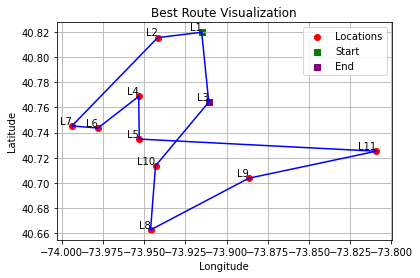

In [84]:
import matplotlib.pyplot as plt

# Plot all locations
all_latitudes, all_longitudes = zip(*test_locations.values())
plt.scatter(all_longitudes, all_latitudes, c='red', marker='o', label='Locations')

# Plot lines connecting all locations in the order of the best guess
for i in range(len(best_guess) - 1):
    start_point = test_locations[best_guess[i]]
    end_point = test_locations[best_guess[i + 1]]
    plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], c='blue', linestyle='-')

# Highlight the starting point
plt.scatter(start_point[1], start_point[0], c='green', marker='s', label='Start')

# Highlight the ending point
plt.scatter(end_point[1], end_point[0], c='purple', marker='s', label='End')

# Annotate each point with its identifier (L1, L2, L3, ...)
for point_id, point in test_locations.items():
    plt.annotate(point_id, (point[1], point[0]), fontsize=10, ha='right', va='bottom')

# Set labels and title
plt.title('Best Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()